In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import keras
from sklearn.metrics import (ConfusionMatrixDisplay,PrecisionRecallDisplay,RocCurveDisplay,confusion_matrix,accuracy_score,
    precision_score,recall_score,f1_score,roc_curve,precision_recall_curve,roc_auc_score,average_precision_score,auc)



In [ ]:
CLEAN_DATA_FOLDER = "/content/drive/Shareddrives/Data 270 DAP Group Project_QQP/clean_data"
MODEL_DATA_FOLDER = "/content/drive/Shareddrives/Data 270 DAP Group Project_QQP/final/LSTM - Saumya"
LEARNING_RATE = 1e-3  # Adjusted learning rate
BATCH_SIZE = 64  # Adjusted batch size for potentially better learning
EPOCHS = 30  # Adjusted number of epochs to avoid overfitting

# Load and prepare training data
train_df = pd.read_csv(
    os.path.join(CLEAN_DATA_FOLDER, "train_final.tsv"),
    sep="\t",
    converters={
        "question1": lambda x: [int(val) for val in x.strip("[]").split(", ")],
        "question2": lambda x: [int(val) for val in x.strip("[]").split(", ")],
    }
)

# validation_df = pd.read_csv(
#     os.path.join(CLEAN_DATA_FOLDER, "validation.tsv"),
#     sep="\t",
#     converters={
#         "question1": lambda x: [int(val) for val in x.strip("[]").split(", ")],
#         "question2": lambda x: [int(val) for val in x.strip("[]").split(", ")],
#     },
# )


In [ ]:

# Convert lists into TensorFlow ragged tensors
train_X_0 = tf.ragged.constant(train_df["question1"].tolist())
train_X_1 = tf.ragged.constant(train_df["question2"].tolist())
train_Y = tf.ragged.constant(train_df["is_duplicate"].tolist(), dtype=tf.float32)

# validation_X_0 = tf.ragged.constant(validation_df["question1"].tolist())
# validation_X_1 = tf.ragged.constant(validation_df["question2"].tolist())
# validation_Y = tf.ragged.constant(validation_df["is_duplicate"].tolist(), dtype=tf.float32)

# Function to pad inputs for uniformity
def pad_inputs(inputs, outputs):
    return (
        (inputs[0].to_tensor(default_value=0), inputs[1].to_tensor(default_value=0)),
        tf.expand_dims(outputs, axis=-1),
    )



In [ ]:

# Prepare dataset for training and validation
train_dataset = tf.data.Dataset.from_tensor_slices(((train_X_0, train_X_1), train_Y))
train_dataset = train_dataset.shuffle(buffer_size=len(train_df)).batch(BATCH_SIZE).map(pad_inputs).prefetch(buffer_size=tf.data.AUTOTUNE)

# validation_dataset = tf.data.Dataset.from_tensor_slices(((validation_X_0, validation_X_1), validation_Y))
# validation_dataset = validation_dataset.batch(BATCH_SIZE).map(pad_inputs).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
def get_embedding_layer(embed_name="fasttext", embed_dim=100):
    embedding_matrix = np.load(os.path.join(CLEAN_DATA_FOLDER, f"{embed_name}.{embed_dim}d.embeddings.npy"))
    embedding_layer = keras.layers.Embedding(embedding_matrix.shape[0], embed_dim, name=f"{embed_name}")
    embedding_layer.build((1,))
    embedding_layer.trainable = False
    embedding_layer.set_weights([embedding_matrix])
    return embedding_layer

In [ ]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Lambda, Subtract

# Model creation function
def create_lstm_model(embed_name="fasttext", embed_dim=100):
    question1 = Input(shape=(None,), dtype='int32', name="question1")
    question2 = Input(shape=(None,), dtype='int32', name="question2")

    embedding_layer = get_embedding_layer(embed_name, embed_dim)

    q1_embed = embedding_layer(question1)
    q2_embed = embedding_layer(question2)

    lstm_layer = keras.layers.LSTM(128, return_sequences=False)
    q1_encoded = lstm_layer(q1_embed)
    q2_encoded = lstm_layer(q2_embed)

    concatenated = keras.layers.concatenate([q1_encoded, q2_encoded])
    dense1 = keras.layers.Dense(64, activation='relu')(concatenated)
    output = keras.layers.Dense(1, activation='sigmoid')(dense1)

    model = keras.Model(inputs=[question1, question2], outputs=output)
    return model

model = create_lstm_model("glove", 100)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 question1 (InputLayer)      [(None, None)]               0         []                            
                                                                                                  
 question2 (InputLayer)      [(None, None)]               0         []                            
                                                                                                  
 glove (Embedding)           (None, None, 100)            1128020   ['question1[0][0]',           
                                                          0          'question2[0][0]']           
                                                                                                  
 lstm (LSTM)                 (None, 128)                  117248    ['glove[0][0]',           

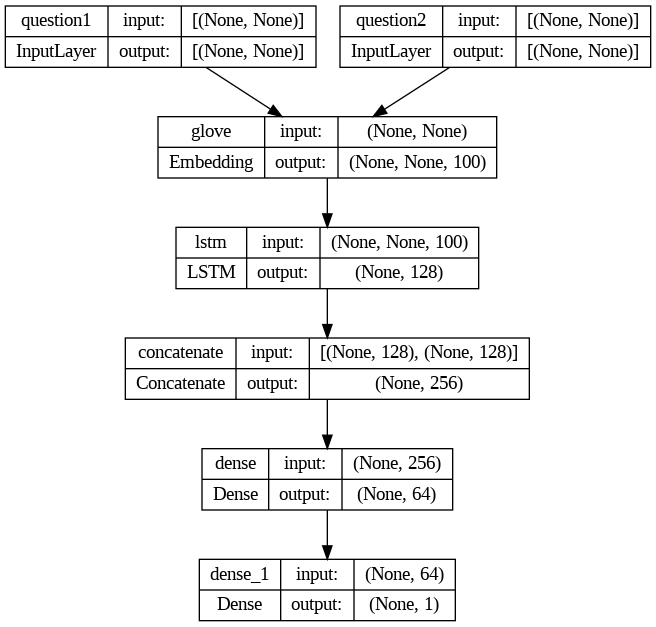

In [ ]:
keras.utils.plot_model(
    model,
    to_file=os.path.join(MODEL_DATA_FOLDER, "lstm_model_glove.png"),
    show_shapes=True,
    show_layer_names=True,
)

In [ ]:

# Model compilation
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()]
)

# Model training
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    # validation_data=validation_dataset,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=5, restore_best_weights=True)]
)

Epoch 1/30
6802/6804 [============================>.] - ETA: 0s - loss: 0.5062 - binary_accuracy: 0.7425 - auc: 0.8261

6804/6804 [==============================] - 62s 8ms/step - loss: 0.5062 - binary_accuracy: 0.7425 - auc: 0.8261
Epoch 2/30
6804/6804 [==============================] - ETA: 0s - loss: 0.4323 - binary_accuracy: 0.7915 - auc: 0.8789

6804/6804 [==============================] - 53s 8ms/step - loss: 0.4323 - binary_accuracy: 0.7915 - auc: 0.8789
Epoch 3/30
6804/6804 [==============================] - ETA: 0s - loss: 0.3924 - binary_accuracy: 0.8150 - auc: 0.9021

6804/6804 [==============================] - 55s 8ms/step - loss: 0.3924 - binary_accuracy: 0.8150 - auc: 0.9021
Epoch 4/30
6800/6804 [============================>.] - ETA: 0s - loss: 0.3613 - binary_accuracy: 0.8322 - auc: 0.9178

6804/6804 [==============================] - 53s 8ms/step - loss: 0.3613 - binary_accuracy: 0.8321 - auc: 0.9177
Epoch 5/30
6798/6804 [============================>.] - ETA: 0s - loss: 0.3362 - binary_accuracy: 0.8459 - auc: 0.9293

6804/6804 [==============================] - 53s 8ms/step - loss: 0.3362 - binary_accuracy: 0.8459 - auc: 0.9293
Epoch 6/30
6801/6804 [============================>.] - ETA: 0s - loss: 0.3151 - binary_accuracy: 0.8571 - auc: 0.9382

6804/6804 [==============================] - 53s 8ms/step - loss: 0.3151 - binary_accuracy: 0.8571 - auc: 0.9382
Epoch 7/30
6802/6804 [============================>.] - ETA: 0s - loss: 0.2959 - binary_accuracy: 0.8681 - auc: 0.9457

6804/6804 [==============================] - 54s 8ms/step - loss: 0.2958 - binary_accuracy: 0.8681 - auc: 0.9457
Epoch 8/30
6801/6804 [============================>.] - ETA: 0s - loss: 0.2792 - binary_accuracy: 0.8765 - auc: 0.9517

6804/6804 [==============================] - 54s 8ms/step - loss: 0.2792 - binary_accuracy: 0.8765 - auc: 0.9517
Epoch 9/30
6800/6804 [============================>.] - ETA: 0s - loss: 0.2648 - binary_accuracy: 0.8837 - auc: 0.9566

6804/6804 [==============================] - 52s 7ms/step - loss: 0.2647 - binary_accuracy: 0.8837 - auc: 0.9566
Epoch 10/30
6798/6804 [============================>.] - ETA: 0s - loss: 0.2510 - binary_accuracy: 0.8904 - auc: 0.9610

6804/6804 [==============================] - 54s 8ms/step - loss: 0.2510 - binary_accuracy: 0.8904 - auc: 0.9610
Epoch 11/30
6798/6804 [============================>.] - ETA: 0s - loss: 0.2395 - binary_accuracy: 0.8959 - auc: 0.9644

6804/6804 [==============================] - 54s 8ms/step - loss: 0.2395 - binary_accuracy: 0.8959 - auc: 0.9644
Epoch 12/30
6801/6804 [============================>.] - ETA: 0s - loss: 0.2286 - binary_accuracy: 0.9011 - auc: 0.9675

6804/6804 [==============================] - 52s 7ms/step - loss: 0.2286 - binary_accuracy: 0.9011 - auc: 0.9675
Epoch 13/30
6802/6804 [============================>.] - ETA: 0s - loss: 0.2194 - binary_accuracy: 0.9059 - auc: 0.9700

6804/6804 [==============================] - 54s 8ms/step - loss: 0.2194 - binary_accuracy: 0.9059 - auc: 0.9700
Epoch 14/30
6802/6804 [============================>.] - ETA: 0s - loss: 0.2111 - binary_accuracy: 0.9104 - auc: 0.9722

6804/6804 [==============================] - 53s 8ms/step - loss: 0.2111 - binary_accuracy: 0.9104 - auc: 0.9722
Epoch 15/30
6799/6804 [============================>.] - ETA: 0s - loss: 0.2031 - binary_accuracy: 0.9141 - auc: 0.9742

6804/6804 [==============================] - 54s 8ms/step - loss: 0.2032 - binary_accuracy: 0.9141 - auc: 0.9742
Epoch 16/30
6802/6804 [============================>.] - ETA: 0s - loss: 0.1972 - binary_accuracy: 0.9164 - auc: 0.9757

6804/6804 [==============================] - 53s 8ms/step - loss: 0.1972 - binary_accuracy: 0.9164 - auc: 0.9757
Epoch 17/30
6802/6804 [============================>.] - ETA: 0s - loss: 0.1903 - binary_accuracy: 0.9200 - auc: 0.9773

6804/6804 [==============================] - 53s 8ms/step - loss: 0.1904 - binary_accuracy: 0.9200 - auc: 0.9773
Epoch 18/30
6797/6804 [============================>.] - ETA: 0s - loss: 0.1849 - binary_accuracy: 0.9226 - auc: 0.9785

6804/6804 [==============================] - 54s 8ms/step - loss: 0.1849 - binary_accuracy: 0.9226 - auc: 0.9785
Epoch 19/30
6799/6804 [============================>.] - ETA: 0s - loss: 0.1805 - binary_accuracy: 0.9246 - auc: 0.9795

6804/6804 [==============================] - 54s 8ms/step - loss: 0.1805 - binary_accuracy: 0.9246 - auc: 0.9795
Epoch 20/30
6802/6804 [============================>.] - ETA: 0s - loss: 0.1752 - binary_accuracy: 0.9268 - auc: 0.9807

6804/6804 [==============================] - 53s 8ms/step - loss: 0.1752 - binary_accuracy: 0.9268 - auc: 0.9807
Epoch 21/30
6800/6804 [============================>.] - ETA: 0s - loss: 0.1705 - binary_accuracy: 0.9294 - auc: 0.9816

6804/6804 [==============================] - 53s 8ms/step - loss: 0.1705 - binary_accuracy: 0.9294 - auc: 0.9816
Epoch 22/30
6800/6804 [============================>.] - ETA: 0s - loss: 0.1674 - binary_accuracy: 0.9309 - auc: 0.9823

6804/6804 [==============================] - 53s 8ms/step - loss: 0.1674 - binary_accuracy: 0.9309 - auc: 0.9823
Epoch 23/30
6798/6804 [============================>.] - ETA: 0s - loss: 0.1636 - binary_accuracy: 0.9322 - auc: 0.9831

6804/6804 [==============================] - 55s 8ms/step - loss: 0.1637 - binary_accuracy: 0.9322 - auc: 0.9831
Epoch 24/30
6801/6804 [============================>.] - ETA: 0s - loss: 0.1597 - binary_accuracy: 0.9341 - auc: 0.9838

6804/6804 [==============================] - 53s 8ms/step - loss: 0.1597 - binary_accuracy: 0.9341 - auc: 0.9838
Epoch 25/30
6803/6804 [============================>.] - ETA: 0s - loss: 0.1572 - binary_accuracy: 0.9352 - auc: 0.9843

6804/6804 [==============================] - 53s 8ms/step - loss: 0.1572 - binary_accuracy: 0.9352 - auc: 0.9843
Epoch 26/30
6802/6804 [============================>.] - ETA: 0s - loss: 0.1552 - binary_accuracy: 0.9359 - auc: 0.9847

6804/6804 [==============================] - 53s 8ms/step - loss: 0.1552 - binary_accuracy: 0.9360 - auc: 0.9847
Epoch 27/30
6801/6804 [============================>.] - ETA: 0s - loss: 0.1516 - binary_accuracy: 0.9376 - auc: 0.9853

6804/6804 [==============================] - 54s 8ms/step - loss: 0.1516 - binary_accuracy: 0.9376 - auc: 0.9853
Epoch 28/30
6797/6804 [============================>.] - ETA: 0s - loss: 0.1492 - binary_accuracy: 0.9394 - auc: 0.9858

6804/6804 [==============================] - 53s 8ms/step - loss: 0.1492 - binary_accuracy: 0.9394 - auc: 0.9858
Epoch 29/30
6802/6804 [============================>.] - ETA: 0s - loss: 0.1476 - binary_accuracy: 0.9396 - auc: 0.9861

6804/6804 [==============================] - 54s 8ms/step - loss: 0.1475 - binary_accuracy: 0.9396 - auc: 0.9861
Epoch 30/30
6804/6804 [==============================] - ETA: 0s - loss: 0.1449 - binary_accuracy: 0.9411 - auc: 0.9866

6804/6804 [==============================] - 52s 7ms/step - loss: 0.1449 - binary_accuracy: 0.9411 - auc: 0.9866


In [ ]:
# to save model
model.save(os.path.join(MODEL_DATA_FOLDER, "lstm_glove_final.keras"))

In [ ]:
#load model
loaded_model = keras.saving.load_model(os.path.join(MODEL_DATA_FOLDER, "lstm_glove_final.keras"))

In [ ]:
# Load test data
test_df = pd.read_csv(
    os.path.join(CLEAN_DATA_FOLDER, "test.tsv"),
    sep="\t",
    converters={
        "question1": lambda x: [int(val) for val in x.strip("[]").split(", ")],
        "question2": lambda x: [int(val) for val in x.strip("[]").split(", ")],
    }
)

# Convert lists into TensorFlow ragged tensors
test_X_0 = tf.ragged.constant(test_df["question1"].tolist())
test_X_1 = tf.ragged.constant(test_df["question2"].tolist())
test_Y = tf.ragged.constant(test_df["is_duplicate"].tolist(), dtype=tf.float32)

# Function to pad inputs for uniformity, reused from earlier
def pad_inputs(inputs, outputs):
    return (
        (inputs[0].to_tensor(default_value=0), inputs[1].to_tensor(default_value=0)),
        tf.expand_dims(outputs, axis=-1),
    )

# Prepare dataset for testing
test_dataset = tf.data.Dataset.from_tensor_slices(((test_X_0, test_X_1), test_Y))
test_dataset = test_dataset.batch(BATCH_SIZE).map(pad_inputs).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# # Load validation data
# validation_df = pd.read_csv(
#     os.path.join(CLEAN_DATA_FOLDER, "validation.tsv"),
#     sep="\t",
#     converters={
#         "question1": lambda x: [int(val) for val in x.strip("[]").split(", ")],
#         "question2": lambda x: [int(val) for val in x.strip("[]").split(", ")],
#     }
# )

# # Convert lists into TensorFlow ragged tensors
# val_X_0 = tf.ragged.constant(validation_df["question1"].tolist())
# val_X_1 = tf.ragged.constant(validation_df["question2"].tolist())
# val_Y = tf.ragged.constant(validation_df["is_duplicate"].tolist(), dtype=tf.float32)

# # Function to pad inputs for uniformity, reused from earlier
# def pad_inputs(inputs, outputs):
#     return (
#         (inputs[0].to_tensor(default_value=0), inputs[1].to_tensor(default_value=0)),
#         tf.expand_dims(outputs, axis=-1),
#     )

# # Prepare dataset for validating
# val_dataset = tf.data.Dataset.from_tensor_slices(((val_X_0, val_X_1), val_Y))
# val_dataset = val_dataset.batch(BATCH_SIZE).map(pad_inputs).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Evaluate the model on the test set
evaluation_results = loaded_model.evaluate(test_dataset)
print("Test Loss:", evaluation_results[0])
print("Test Binary Accuracy:", evaluation_results[1])
print("Test AUC:", evaluation_results[2])

632/632 [==============================] - 24s 36ms/step - loss: 0.6432 - binary_accuracy: 0.8186 - auc: 0.8811
Test Loss: 0.6431708931922913
Test Binary Accuracy: 0.8186385035514832
Test AUC: 0.8811302781105042


In [ ]:
evaluation_results

[0.6431708931922913, 0.8186385035514832, 0.8811302781105042]

In [ ]:
# Evaluate the model on the validation set
evaluation_results_val = loaded_model.evaluate(val_dataset)
print("Validation Loss:", evaluation_results_val[0])
print("Validation Binary Accuracy:", evaluation_results_val[1])
print("Validation AUC:", evaluation_results_val[2])

632/632 [==============================] - 7s 4ms/step - loss: 0.4848 - binary_accuracy: 0.8171 - auc: 0.8858
Validation Loss: 0.4848001003265381
Validation Binary Accuracy: 0.8171244859695435
Validation AUC: 0.8857858777046204


In [ ]:
test_y_pred = loaded_model.predict(test_dataset)
test_results_df = pd.DataFrame(
    {
        "y_true": test_df["is_duplicate"].tolist(),
        "y_pred": test_y_pred.round().astype(int).squeeze().tolist(),
        "y_score": test_y_pred.squeeze().tolist(),
    }
)

632/632 [==============================] - 26s 37ms/step


In [ ]:
validation_metrics = {
    "Accuracy": {},
    "Precision": {},
    "Recall": {},
    "F1": {},
    "ROC AUC": {},
    "PR AUC": {}
}

model_name = "LSTM (GloVe)"

In [ ]:
accuracy = accuracy_score(test_results_df["y_true"], test_results_df["y_pred"])
precision = precision_score(test_results_df["y_true"], test_results_df["y_pred"])
recall = recall_score(test_results_df["y_true"], test_results_df["y_pred"])
f1 = f1_score(test_results_df["y_true"], test_results_df["y_pred"])
auc_roc = roc_auc_score(test_results_df["y_true"], test_results_df["y_score"])
pr, re, _ = precision_recall_curve(
    test_results_df["y_true"], test_results_df["y_score"], pos_label=1
)
auc_pr = auc(re, pr)
validation_metrics["Accuracy"][model_name] = accuracy
validation_metrics["Precision"][model_name] = precision
validation_metrics["Recall"][model_name] = recall
validation_metrics["F1"][model_name] = f1
validation_metrics["ROC AUC"][model_name] = auc_roc
validation_metrics["PR AUC"][model_name] = auc_pr
pd.DataFrame(validation_metrics)
pd.DataFrame(validation_metrics).to_csv("temp_results.csv", index_label="Model")
pd.DataFrame(validation_metrics)

,Accuracy,Precision,Recall,F1,ROC AUC,PR AUC
LSTM (GloVe),0.818638,0.738856,0.79322,0.765074,0.888206,0.834705


In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(test_results_df["y_true"], test_results_df["y_pred"])

print("Confusion Matrix:")
print(cm)

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])

cm_display.plot()
plt.show()

# **Inferencing**

In [ ]:
import pandas as pd
import tensorflow as tf

# Load the vocabulary
vocab_path = '/content/drive/MyDrive/clean_data/vocab.tsv'
vocab = pd.read_csv(vocab_path, sep='\t')
vocab_mapping = {row['token']: row['id'] for index, row in vocab.iterrows()}

In [ ]:
def tokenize_and_encode(question, vocab_mapping, max_length=64):
    # Convert text to lowercase, then to words (tokens)
    tokens = tf.keras.preprocessing.text.text_to_word_sequence(question)

    # Replace each token with its corresponding ID from the vocab_mapping
    encoded = [vocab_mapping.get(token, 0) for token in tokens]  # Use 0 for unknown words

    # Pad the sequences to ensure uniform input size
    padded = tf.keras.preprocessing.sequence.pad_sequences([encoded], maxlen=max_length, padding='post')
    return padded


In [ ]:
def predict_similarity(question1, question2, vocab_mapping, model, max_length=64):
    # Encode the questions
    q1_encoded = tokenize_and_encode(question1, vocab_mapping, max_length)
    q2_encoded = tokenize_and_encode(question2, vocab_mapping, max_length)

    # Predict using the trained LSTM model
    prediction = model.predict([q1_encoded, q2_encoded])

    # Interpret the prediction as similar or not based on a threshold (e.g., 0.5)
    is_similar = 'Similar' if prediction[0][0] > 0.5 else 'Not Similar'

    return is_similar


In [ ]:
# Example questions
question1 = "How can I improve my English speaking?"
question2 = "What are some ways to become better at speaking English?"

# Assuming 'model' is your trained LSTM model
result = predict_similarity(question1, question2, vocab_mapping, model)
print("The questions are:", result)


1/1 [==============================] - 1s 719ms/step
The questions are: Similar


In [ ]:
# Example questions
question2 = "How to run GPU on colab ?"
question3 = "I am not able to run GPU, can someone tell me the steps for it ?"

# Assuming 'model' is your trained LSTM model
result = predict_similarity(question2, question3, vocab_mapping, model)
print("The questions are:", result)


1/1 [==============================] - 0s 63ms/step
The questions are: Similar
